# Visualizing model performance
This notebook is a minimal guide to visualize Detectron2 model performance



In [31]:
#required imports
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import LazyConfig, get_cfg, instantiate
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine.defaults import create_ddp_model
from detectron2.checkpoint import DetectionCheckpointer

_original_torch_load = torch.load
def patched_torch_load(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return _original_torch_load(*args, **kwargs)

Here we input the **paths to our model files**. 

In [32]:
#update these paths to your dataset and trained model
TRAINED_MODEL_DIR = "/scratch/ajitj_root/ajitj99/anishjv/vitl_focal_hela_0.2"  # from config.yaml: train:output_dir
CONFIG_FILE = "/scratch/ajitj_root/ajitj99/anishjv/vitl_focal_hela_0.2/config_test.yaml"  # the same config used for training
TEST_DATASET_JSON = "/home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/hela_0.2_test.json"
TEST_IMAGE_DIR = "/home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/images/"

Here we **register the testing dataset** we want to run inference on. 

In [33]:
#register the test dataset
dataset_name = "HeLa_test_0.2"
if dataset_name not in DatasetCatalog.list():
    register_coco_instances(
        dataset_name,
        {},
        TEST_DATASET_JSON,
        TEST_IMAGE_DIR
    )

metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

Here we **configure the model**.

In [52]:
#load the trained model
cfg = LazyConfig.load(CONFIG_FILE)
cfg.train.output_dir = TRAINED_MODEL_DIR
cfg.train.init_checkpoint = os.path.join(TRAINED_MODEL_DIR, "model_final.pth")  # adjust if checkpoint name differs
cfg.train.device = "cuda" if torch.cuda.is_available() else "cpu"
cfg.model.proposal_generator.post_nms_topk[1] = 1000 #maximum number of cells
cfg.model.roi_heads.box_predictor.test_score_thresh = 0.5 #minimum prediction confidence

predictor = instantiate(cfg.model)
predictor.to(cfg.train.device)
predictor = create_ddp_model(predictor)
torch.load = patched_torch_load
DetectionCheckpointer(predictor).load(cfg.train.init_checkpoint)
torch.load = _original_torch_load
predictor.eval()

GeneralizedRCNN(
  (backbone): SimpleFeaturePyramid(
    (simfp_2): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
      (1): LayerNorm()
      (2): GELU(approximate='none')
      (3): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
      (4): Conv2d(
        256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
        (norm): LayerNorm()
      )
      (5): Conv2d(
        256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        (norm): LayerNorm()
      )
    )
    (simfp_3): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
      (1): Conv2d(
        512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
        (norm): LayerNorm()
      )
      (2): Conv2d(
        256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        (norm): LayerNorm()
      )
    )
    (simfp_4): Sequential(
      (0): Conv2d(
        1024, 256, kernel_size=(1, 1), stride=(1, 

Below is a **helper function** for visualization. 

In [55]:
#helper function for visualizing predictions
def visualize_predictions(image_path, predictor, metadata):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_perm = np.moveaxis(img_rgb, -1, 0)
    
    with torch.inference_mode():
        outputs = predictor(
            [{"image": torch.from_numpy(img_perm).type(torch.float32)}]
        )[0]
    
    v = Visualizer(img_rgb, metadata=metadata, scale=8, instance_mode=ColorMode.IMAGE)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()

Visualizing /home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/images/368.jpg


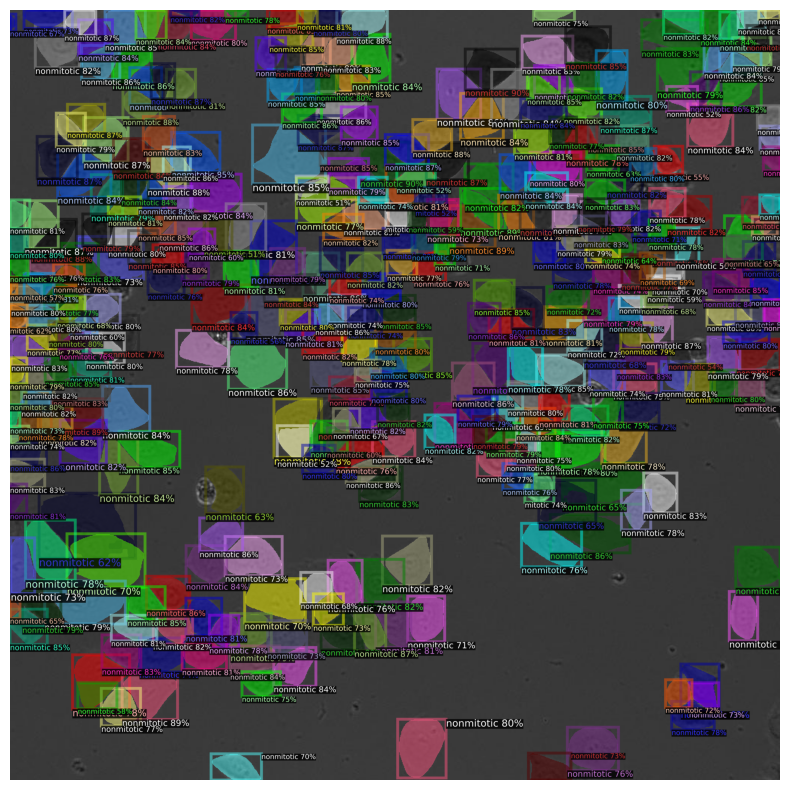

Visualizing /home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/images/359.jpg


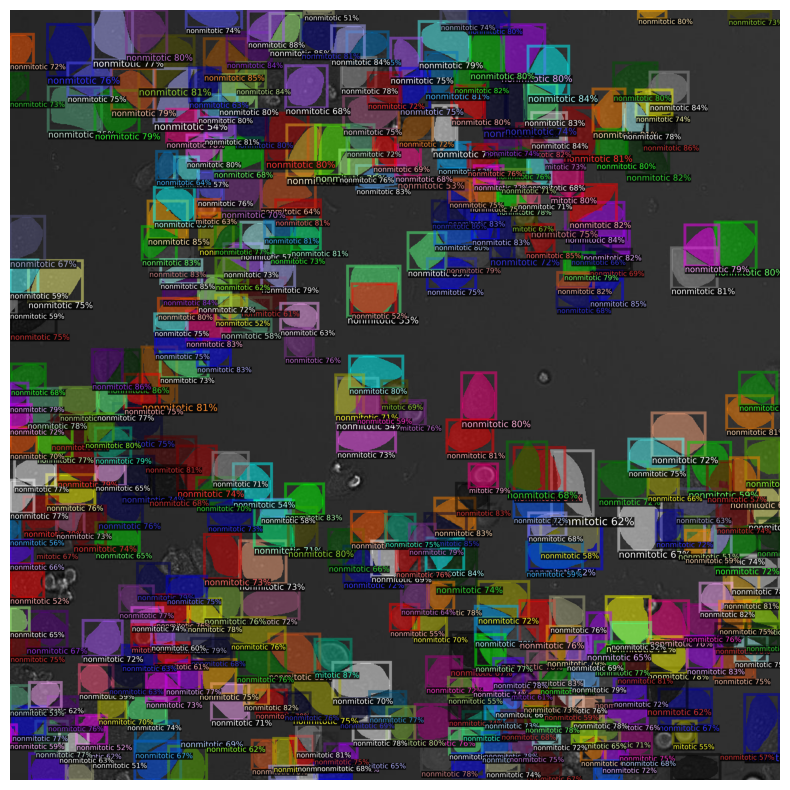

Visualizing /home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/images/325.jpg


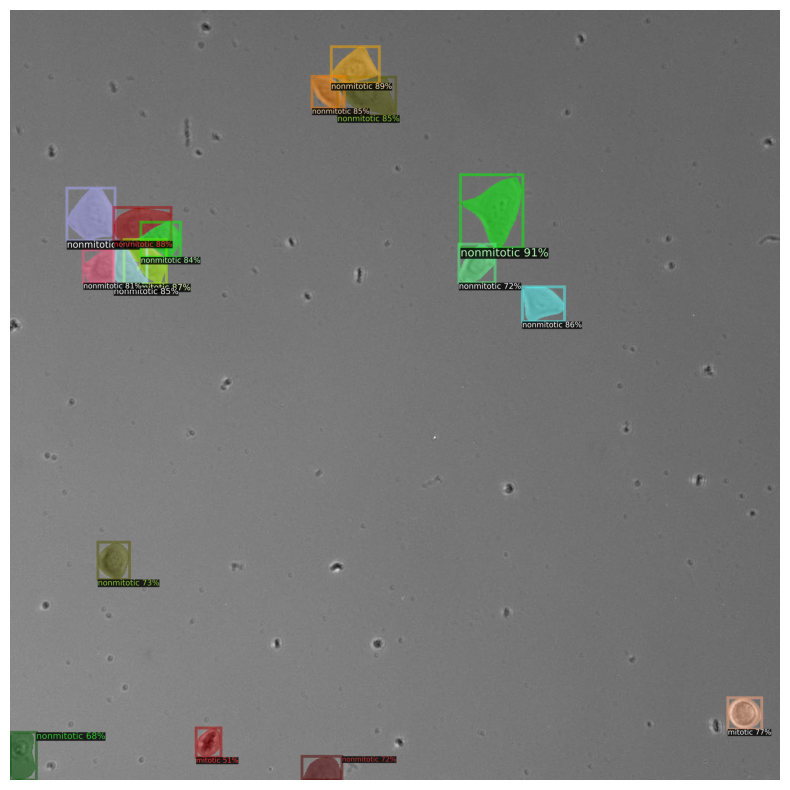

Visualizing /home/anishjv/cell_seg_classify/datasets/HeLa_0.2/test/images/390.jpg


In [ ]:
#visualize some images test set
for i, d in enumerate(dataset_dicts[5:10]):
    print(f"Visualizing {d['file_name']}")
    visualize_predictions(d["file_name"], predictor, metadata)